In [29]:
# Install required data/science packages (idempotent)
import sys, subprocess, pkgutil
packages = ["pandas", "numpy", "matplotlib", "seaborn", "joblib", "scikit-learn", "tqdm"]
missing = [pkg for pkg in packages if not pkgutil.find_loader(pkg.split('-')[0])]
if missing:
    print("Installing missing packages:", missing)
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages already installed.")


Installing missing packages: ['pandas', 'numpy', 'matplotlib', 'seaborn', 'joblib', 'scikit-learn', 'tqdm']



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

In [2]:
# Cell 2: Paths (adjust if your files are in a different location)
PAYLOAD_FILE = 'data/payload.txt' # malicious payloads (one payload per line)
GOOD_FILE = 'data/good.txt' # benign parameter values (one per line)
ARTIFACT_DIR = 'models'
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [3]:
# Cell 3: Load raw data
def load_lines_strip(path):
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    return lines


malicious = load_lines_strip(PAYLOAD_FILE)
benign = load_lines_strip(GOOD_FILE)


print(f"Loaded {len(malicious)} malicious samples and {len(benign)} benign samples.")


# Cell 4: Create DataFrame and label
df_m = pd.DataFrame({'payload': malicious, 'label': 1}) # 1 = malicious
df_b = pd.DataFrame({'payload': benign, 'label': 0}) # 0 = benign


df = pd.concat([df_m, df_b], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

Loaded 3290 malicious samples and 15257 benign samples.


In [4]:
# Basic cleanup (customize as needed)
def normalize_text(s):
    s = s.lower()
    s = s.strip()
    return s

df['payload_clean'] = df['payload'].astype(str).apply(normalize_text)

In [6]:
# Cell 5: Quick EDA
print(df['label'].value_counts())
print(df.head())


# Optionally inspect example malicious vs benign
print('\nExample malicious:\n', df[df.label==1].payload_clean.sample(5, random_state=1).tolist()[:5])
print('\nExample benign:\n', df[df.label==0].payload_clean.sample(5, random_state=1).tolist()[:5])

label
0    15257
1     3290
Name: count, dtype: int64
    payload  label payload_clean
0  altitude      0      altitude
1  robotics      0      robotics
2   Nicolas      0       nicolas
3  sampling      0      sampling
4    Cesare      0        cesare

Example malicious:
 ['23%29%20and%202874%20like%202341%20and%20%288194%20like%208194', "b'/**/or/**/1/**/=/**/1'", 'admin" #', "b'10+union+select+load_file(0x2f6574632f706173737764)'", 'b"\' or 3=3"']

Example benign:
 ['minette', 'massive', 'moustache', 'buda', 'clammy']


In [ ]:
# Cell 6: Train/test split
X = df['payload_clean'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
# Cell 7: Vectorization -- char n-grams often work well for payload detection
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,6), max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print('Vectorized shape:', X_train_vec.shape, X_test_vec.shape)

Vectorized shape: (14837, 20000) (3710, 20000)


In [10]:
# Cell 8: Baseline Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Quick grid search for DecisionTree (keep small to save time)
dt_params = {
'max_depth': [10, 20, 40, None],
'min_samples_split': [2, 5, 10]
}

gs_dt = GridSearchCV(dt, dt_params, cv=3, scoring='f1', n_jobs=-1)
print('Training DecisionTree...')
gs_dt.fit(X_train_vec, y_train)
print('Best DT params:', gs_dt.best_params_)

best_dt = gs_dt.best_estimator_

# Evaluate DT
y_pred_dt = best_dt.predict(X_test_vec)

print('\nDecision Tree Classification Report:\n')
print(classification_report(y_test, y_pred_dt, digits=4))

# Save DT
joblib.dump(best_dt, os.path.join(ARTIFACT_DIR, 'decision_tree.joblib'))

Training DecisionTree...
Best DT params: {'max_depth': 40, 'min_samples_split': 2}

Decision Tree Classification Report:

              precision    recall  f1-score   support

           0     0.9925    0.9984    0.9954      3052
           1     0.9922    0.9650    0.9784       658

    accuracy                         0.9925      3710
   macro avg     0.9923    0.9817    0.9869      3710
weighted avg     0.9925    0.9925    0.9924      3710

Best DT params: {'max_depth': 40, 'min_samples_split': 2}

Decision Tree Classification Report:

              precision    recall  f1-score   support

           0     0.9925    0.9984    0.9954      3052
           1     0.9922    0.9650    0.9784       658

    accuracy                         0.9925      3710
   macro avg     0.9923    0.9817    0.9869      3710
weighted avg     0.9925    0.9925    0.9924      3710



['models/decision_tree.joblib']

In [11]:
# Cell 9: Random Forest
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf_params = {
'n_estimators': [100, 200],
'max_depth': [20, 40, None],
'min_samples_split': [2, 5]
}

gs_rf = GridSearchCV(rf, rf_params, cv=3, scoring='f1', n_jobs=-1)
print('Training RandomForest... (this may take a while)')
gs_rf.fit(X_train_vec, y_train)
print('Best RF params:', gs_rf.best_params_)

best_rf = gs_rf.best_estimator_

# Evaluate RF
y_pred_rf = best_rf.predict(X_test_vec)

print('\nRandom Forest Classification Report:\n')
print(classification_report(y_test, y_pred_rf, digits=4))

# Save RF and vectorizer
joblib.dump(best_rf, os.path.join(ARTIFACT_DIR, 'random_forest.joblib'))
joblib.dump(vectorizer, os.path.join(ARTIFACT_DIR, 'tfidf_vectorizer.joblib'))

Training RandomForest... (this may take a while)
Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Classification Report:

              precision    recall  f1-score   support

           0     0.9961    0.9984    0.9972      3052
           1     0.9923    0.9818    0.9870       658

    accuracy                         0.9954      3710
   macro avg     0.9942    0.9901    0.9921      3710
weighted avg     0.9954    0.9954    0.9954      3710

Best RF params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Classification Report:

              precision    recall  f1-score   support

           0     0.9961    0.9984    0.9972      3052
           1     0.9923    0.9818    0.9870       658

    accuracy                         0.9954      3710
   macro avg     0.9942    0.9901    0.9921      3710
weighted avg     0.9954    0.9954    0.9954      3710



['models/tfidf_vectorizer.joblib']

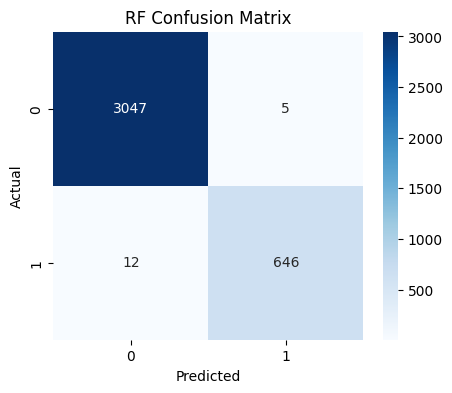

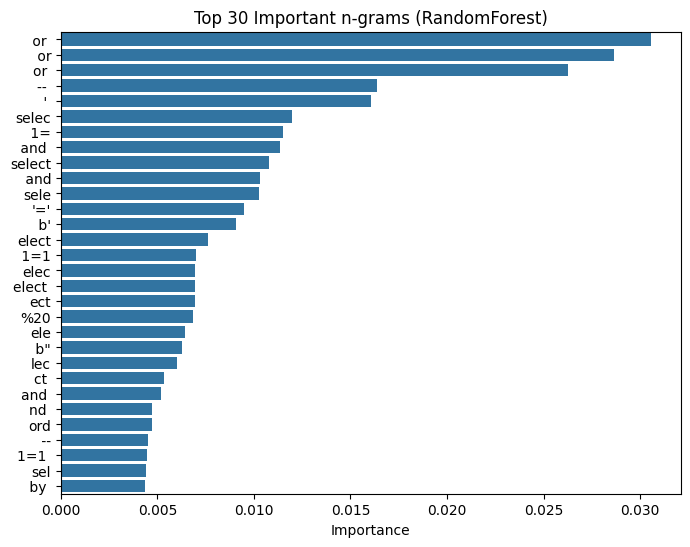

In [12]:
# Cell 10: Confusion matrices and feature importance
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('RF Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importances (only for tree-based models). Show top N char-ngrams
try:
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)[::-1][:30]
    feature_names = np.array(vectorizer.get_feature_names_out())
    top_features = feature_names[indices]
    top_importances = importances[indices]

    plt.figure(figsize=(8,6))
    sns.barplot(x=top_importances, y=top_features)
    plt.title('Top 30 Important n-grams (RandomForest)')
    plt.xlabel('Importance')
    plt.show()
except Exception as e:
    print('Could not compute feature importances:', e)

In [13]:
# Cell 11: Save a small evaluation summary file
with open(os.path.join(ARTIFACT_DIR, 'evaluation_summary.txt'), 'w') as f:
    f.write('Decision Tree report:\n')
    f.write(classification_report(y_test, y_pred_dt, digits=4))
    f.write('\nRandom Forest report:\n')
    f.write(classification_report(y_test, y_pred_rf, digits=4))

print('Artifacts saved in', ARTIFACT_DIR)

Artifacts saved in models
